# Decision Tree Model

In [4]:
import pandas as pd  
from sklearn.ensemble import RandomForestRegressor  
from sklearn.model_selection import train_test_split  
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import time

In [14]:
# Read Dataset
data_path = "results/feature_std.txt"
with open(data_path, "r") as file:
    lines = file.readlines()

distanceList = []
intensityList = []
stdList = []
for line in lines[9:]:
    line = line.split()
    distanceList.append(float(line[0]))
    intensityList.append(float(line[1]))
    stdList.append(float(line[2]))

data = {
    'distance': distanceList, 
    'intensity': intensityList, 
    'std': stdList
}
df = pd.DataFrame(data)  

# Define features and target variable  
X = df[['distance', 'intensity']]  
y = df['std']  

# Split the dataset into training and testing sets  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  

# Initialize and train the Random Forest Regressor model  
model = RandomForestRegressor(n_estimators=100, random_state=42)
begin_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()
print(f'Training Time: {end_time - begin_time}')

# Make predictions  
y_pred = model.predict(X_test)  

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Mean Squared Error: {rmse}')  

# Print predicted and actual results  
# print('Predicted Intensity:', y_pred)  
# print('Actual Intensity:', y_test.values)

Training Time: 0.10590457916259766
Mean Squared Error: 0.02880063750082006


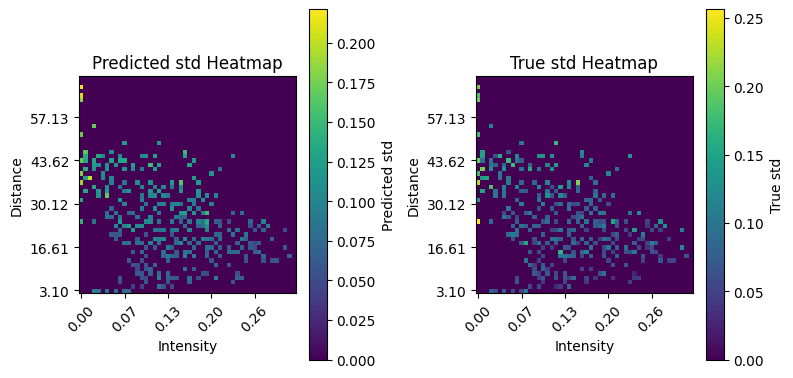

In [6]:
from scipy.stats import binned_statistic_2d

y_pred = model.predict(X_test)

# 定义Bin的数量  
N = 50

# 创建x和y的边界
maxBinDistance = float(lines[4].split()[1])
minBinDistance = float(lines[5].split()[1])
maxBinIntensity = float(lines[6].split()[1])
minBinIntensity = float(lines[7].split()[1])
stepDistance = (maxBinDistance - minBinDistance) / N
binsDistance = np.arange(minBinDistance, maxBinDistance, stepDistance)
stepIntensity = (maxBinIntensity - minBinIntensity) / N
binsIntensity = np.arange(minBinIntensity, maxBinIntensity, stepIntensity)
stdGridTrue = np.zeros((N, N))
stdGridPred = np.zeros((N, N))

X = X_test.copy()
y = y_test.copy()
# 计算每个bin的平均值
for j in range(N - 1):
    for i in range(N - 1):
        mask = (X['distance'] >= binsDistance[j]) & (X['distance'] < binsDistance[j + 1]) & (X['intensity'] >= binsIntensity[i]) & (X['intensity'] < binsIntensity[i + 1])
        if np.sum(mask) == 0:
            continue
        stdGridTrue[i, j] = np.mean(y[mask])
        stdGridPred[i, j] = np.mean(y_pred[mask])

# 绘制热力图  
plt.figure(figsize=(8, 4))  

# 预测值热力图  
plt.subplot(1, 2, 1)  
plt.imshow(stdGridPred.T, interpolation='nearest', origin='lower', cmap='viridis')
plt.colorbar(label='Predicted std')  
plt.xlabel('Intensity')  
plt.ylabel('Distance')
plt.xticks(range(len(binsIntensity))[::10], ["{:.2f}".format(x) for x in binsIntensity[::10]], rotation=45)
plt.yticks(range(len(binsDistance))[::10], ["{:.2f}".format(x) for x in binsDistance[::10]])
plt.title('Predicted std Heatmap')  

# 真实值热力图  
plt.subplot(1, 2, 2)  
plt.imshow(stdGridTrue.T, interpolation='nearest', origin='lower', cmap='viridis')
plt.colorbar(label='True std')  
plt.xlabel('Intensity')  
plt.ylabel('Distance')
plt.xticks(range(len(binsIntensity))[::10], ["{:.2f}".format(x) for x in binsIntensity[::10]], rotation=45)
plt.yticks(range(len(binsDistance))[::10], ["{:.2f}".format(x) for x in binsDistance[::10]])
plt.title('True std Heatmap')  

plt.tight_layout()
plt.savefig('std_heatmap.png', dpi=300)
plt.show()

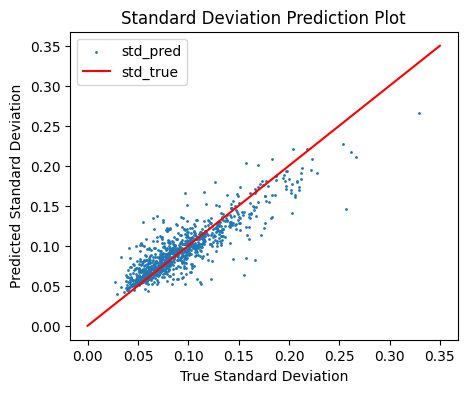

In [9]:
data = {
    'distance': distanceList, 
    'intensity': intensityList, 
    'std': stdList
}
df = pd.DataFrame(data)
X = df[['distance', 'intensity']]
y = model.predict(X)
stdList_pred = y.tolist()

plt.figure(figsize=(5, 4))
plt.scatter(stdList, stdList_pred, s=1, label='std_pred')
plt.plot([0, 0.35], [0, 0.35], color='red', label='std_true')
plt.ylabel('Predicted Standard Deviation')
plt.xlabel('True Standard Deviation')
plt.title('Standard Deviation Prediction Plot')
plt.legend()
plt.savefig('std_prediction_plot.png', dpi=100)
plt.show()

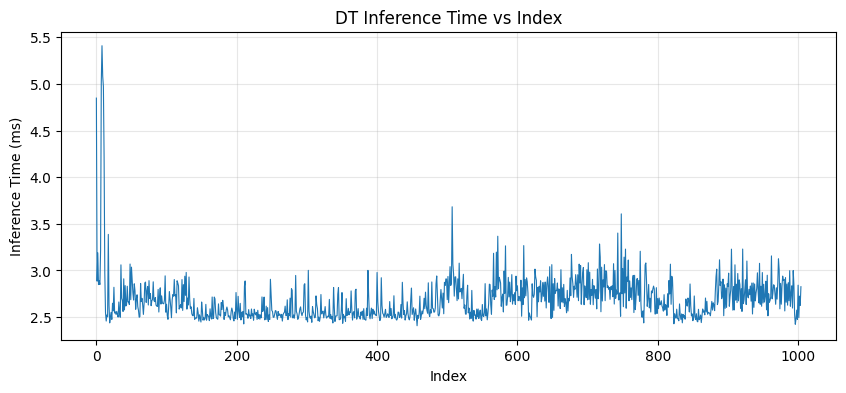

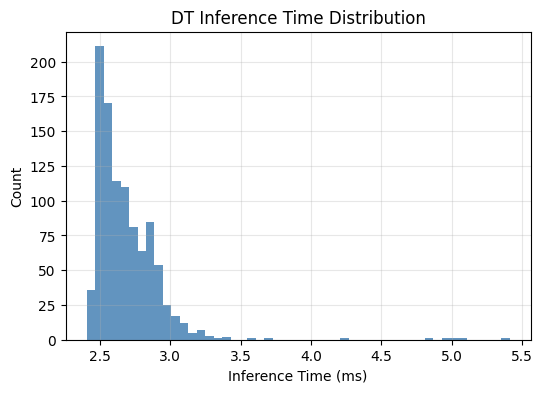

In [15]:
# Inference time per sample (ms)
X_infer = X.copy()
inference_times_ms = []
for i in range(len(X_infer)):
    t0 = time.perf_counter()
    _ = model.predict(X_infer.iloc[i:i+1])
    t1 = time.perf_counter()
    inference_times_ms.append((t1 - t0) * 1000.0)

plt.figure(figsize=(10, 4))
plt.plot(inference_times_ms, lw=0.8)
plt.xlabel('Index')
plt.ylabel('Inference Time (ms)')
plt.title('DT Inference Time vs Index')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(inference_times_ms, bins=50, color='steelblue', alpha=0.85)
plt.xlabel('Inference Time (ms)')
plt.ylabel('Count')
plt.title('DT Inference Time Distribution')
plt.grid(True, alpha=0.3)
plt.show()
